In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)

# Go from evaluation/ -> project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(PROJECT_ROOT)

from utils.mura_dataset import MURADataset
from utils.transforms import get_train_transforms, get_val_transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cpu


In [2]:
#  Dataloader for TEST set
def get_test_loader(batch_size: int = 32):
    data_root = os.path.join(PROJECT_ROOT, "data", "raw")
    test_csv = os.path.join(PROJECT_ROOT, "data", "splits", "valid_labeled_studies.csv")

    test_dataset = MURADataset(
        csv_file=test_csv,
        transform=get_val_transforms(),
        root_dir=data_root,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    print("Test samples:", len(test_dataset))
    return test_loader

test_loader = get_test_loader(batch_size=32)


Test samples: 3197


In [3]:
# Baseline CNN definition (same as Su's training code)
class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # 224x224 -> pool -> 112x112 -> pool -> 56x56, 32 channels
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 16, 112, 112]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 32, 56, 56]
        x = x.view(x.size(0), -1)                 # flatten
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))         # prob in [0, 1]



In [ ]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),   # in: 1 channel, out: 32 feature maps
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
        )

        #Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        #Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Final classifier
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.gap(x)                 # [B, 128, 1, 1]
        x = x.view(x.size(0), -1)       # [B, 128]

        x = self.fc(x)                  # [B, 1]
        return torch.sigmoid(x).squeeze(1)  # [B]


In [ ]:
# Paths and helper to evaluate one model on the test set

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)
import torch

#Paths to histories and weight
BASELINE_WEIGHTS_PATH = os.path.join(PROJECT_ROOT, "models/baseline_cnn.pt")
BASELINE_HISTORY_PATH = os.path.join(PROJECT_ROOT, "evaluation/baseline_history.npz")

MODEL10_WEIGHTS_PATH = os.path.join(PROJECT_ROOT, "models/model1_10ep.pt")
MODEL10_HISTORY_PATH = os.path.join(PROJECT_ROOT, "evaluation/model1_10ep_history.npz")


def load_history(path):
    """Load a .npz training history file."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"History file not found: {path}")
    h = np.load(path)
    return {
        "train_loss": h["train_loss"],
        "val_acc":   h["val_acc"],
        "val_auc":   h["val_auc"],
        "test_acc_hist": float(h["test_acc"]),
        "test_auc_hist": float(h["test_auc"]),
    }


def evaluate_checkpoint(label, weights_path, history_path, model_class):
    """
    Evaluate a saved checkpoint + its training history.

    model_class: the nn.Module class to instantiate (BaselineCNN or DeeperCNN)
    """
    print(f"\n===== Evaluating {label} =====")
    print(f"  Weights: {weights_path}")
    print(f"  History: {history_path}")

    #load training history (loss, val acc, val auc, test metrics
    hist = np.load(history_path)
    train_loss_hist = hist["train_loss"]
    val_acc_hist   = hist["val_acc"]
    val_auc_hist   = hist["val_auc"]
    test_acc_hist  = float(hist["test_acc"])
    test_auc_hist  = float(hist["test_auc"])

    print(f"  Saved test Accuracy (history): {test_acc_hist:.4f}")
    print(f"  Saved test AUC       (history): {test_auc_hist:.4f}")

    #build correct model and load weights
    model = model_class().to(device)
    state = torch.load(weights_path, map_location=device)
    model.load_state_dict(state)
    model.eval()

    #evaluation on TEST set again for sanity / extra metrics
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)  # model outputs probabilities [B] or [B,1]
            if outputs.dim() > 1:
                outputs = outputs.squeeze(1)

            all_probs.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    # threshold at 0.5 for hard preds
    y_pred = (all_probs >= 0.5).astype(int)
    y_true = all_labels.astype(int)

    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred, zero_division=0)
    rec   = recall_score(y_true, y_pred, zero_division=0)
    f1    = f1_score(y_true, y_pred, zero_division=0)
    auc   = roc_auc_score(y_true, all_probs)
    cm    = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)

    print(f"\n[Recomputed on test set] {label}")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1-score : {f1:.4f}")
    print(f"  ROC AUC  : {auc:.4f}")
    print("\nClassification report:\n", report)
    print("Confusion matrix:\n", cm)

    return {
        "label": label,
        "train_loss_hist": train_loss_hist,
        "val_acc_hist": val_acc_hist,
        "val_auc_hist": val_auc_hist,
        "test_acc_hist": test_acc_hist,
        "test_auc_hist": test_auc_hist,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "auc": auc,
        "cm": cm,
        "y_true": y_true,
        "y_prob": all_probs,
    }


In [13]:
# evaluation for baseline (5 ep) and 10-epoch deeper model

baseline_results = evaluate_checkpoint(
    label="Baseline CNN (5 epochs)",
    weights_path=BASELINE_WEIGHTS_PATH,
    history_path=BASELINE_HISTORY_PATH,
    model_class=BaselineCNN,
)

model10_results = evaluate_checkpoint(
    label="Deeper CNN (10 epochs)",
    weights_path=MODEL10_WEIGHTS_PATH,
    history_path=MODEL10_HISTORY_PATH,
    model_class=DeeperCNN,   
)



===== Evaluating Baseline CNN (5 epochs) =====
  Weights: c:\Users\ENOPARA\code\MachineLearning2025Project\cnnradiographproject-n\models/baseline_cnn.pt
  History: c:\Users\ENOPARA\code\MachineLearning2025Project\cnnradiographproject-n\evaluation/baseline_history.npz
  Saved test Accuracy (history): 0.5962
  Saved test AUC       (history): 0.6679

[Recomputed on test set] Baseline CNN (5 epochs)
  Accuracy : 0.5962
  Precision: 0.7057
  Recall   : 0.2680
  F1-score : 0.3884
  ROC AUC  : 0.6679

Classification report:
               precision    recall  f1-score   support

           0       0.57      0.90      0.70      1667
           1       0.71      0.27      0.39      1530

    accuracy                           0.60      3197
   macro avg       0.64      0.58      0.54      3197
weighted avg       0.64      0.60      0.55      3197

Confusion matrix:
 [[1496  171]
 [1120  410]]

===== Evaluating Deeper CNN (10 epochs) =====
  Weights: c:\Users\ENOPARA\code\MachineLearning2025Pro

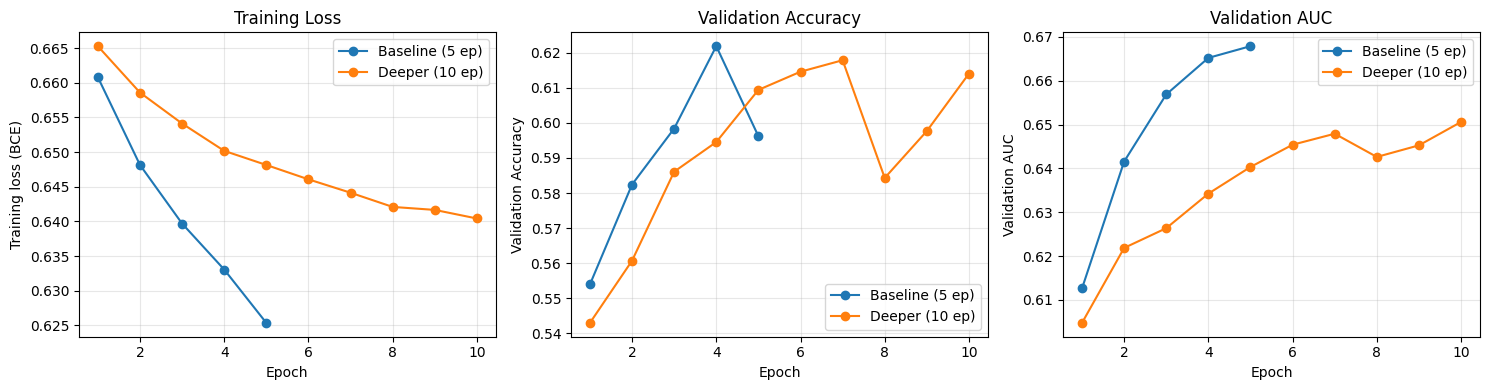

In [15]:
#Training curves comparison (Baseline 5 ep vs Deeper 10 ep)

# Baseline (5 epochs)
base_train_loss = baseline_results["train_loss_hist"]
base_val_acc    = baseline_results["val_acc_hist"]
base_val_auc    = baseline_results["val_auc_hist"]
epochs_base     = range(1, len(base_train_loss) + 1)

# Deeper model (10 epochs)
m10_train_loss = model10_results["train_loss_hist"]
m10_val_acc    = model10_results["val_acc_hist"]
m10_val_auc    = model10_results["val_auc_hist"]
epochs_m10     = range(1, len(m10_train_loss) + 1)

plt.figure(figsize=(15, 4))

# 1) Training loss
plt.subplot(1, 3, 1)
plt.plot(epochs_base, base_train_loss, marker="o", label="Baseline (5 ep)")
plt.plot(epochs_m10, m10_train_loss, marker="o", label="Deeper (10 ep)")
plt.xlabel("Epoch")
plt.ylabel("Training loss (BCE)")
plt.title("Training Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# 2) Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_base, base_val_acc, marker="o", label="Baseline (5 ep)")
plt.plot(epochs_m10, m10_val_acc, marker="o", label="Deeper (10 ep)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# 3) Validation AUC
plt.subplot(1, 3, 3)
plt.plot(epochs_base, base_val_auc, marker="o", label="Baseline (5 ep)")
plt.plot(epochs_m10, m10_val_auc, marker="o", label="Deeper (10 ep)")
plt.xlabel("Epoch")
plt.ylabel("Validation AUC")
plt.title("Validation AUC")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


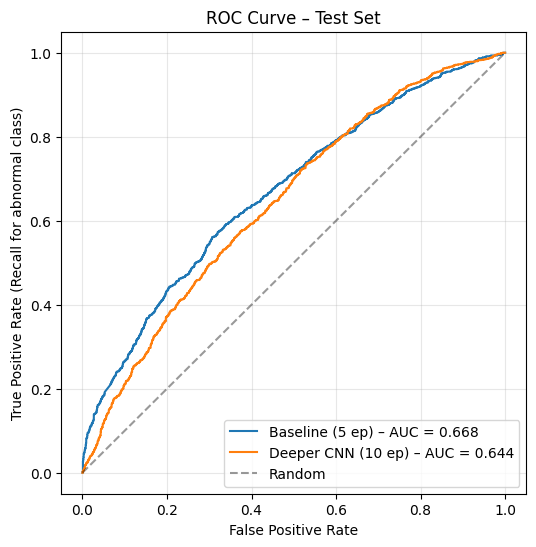

Baseline test AUC: 0.6679
Deeper CNN test AUC: 0.6437


In [16]:
#ROC curves on TEST set (Baseline vs Deeper)

# Baseline
y_true_base = baseline_results["y_true"]
y_prob_base = baseline_results["y_prob"]
fpr_base, tpr_base, _ = roc_curve(y_true_base, y_prob_base)
auc_base = roc_auc_score(y_true_base, y_prob_base)

# Deeper CNN (10 epochs)
y_true_m10 = model10_results["y_true"]
y_prob_m10 = model10_results["y_prob"]
fpr_m10, tpr_m10, _ = roc_curve(y_true_m10, y_prob_m10)
auc_m10 = roc_auc_score(y_true_m10, y_prob_m10)

plt.figure(figsize=(6, 6))
plt.plot(fpr_base, tpr_base, label=f"Baseline (5 ep) – AUC = {auc_base:.3f}")
plt.plot(fpr_m10, tpr_m10, label=f"Deeper CNN (10 ep) – AUC = {auc_m10:.3f}")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4, label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall for abnormal class)")
plt.title("ROC Curve – Test Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Baseline test AUC: {auc_base:.4f}")
print(f"Deeper CNN test AUC: {auc_m10:.4f}")


C:\Users\ENOPARA\AppData\Local\Temp\ipykernel_16780\2515779504.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


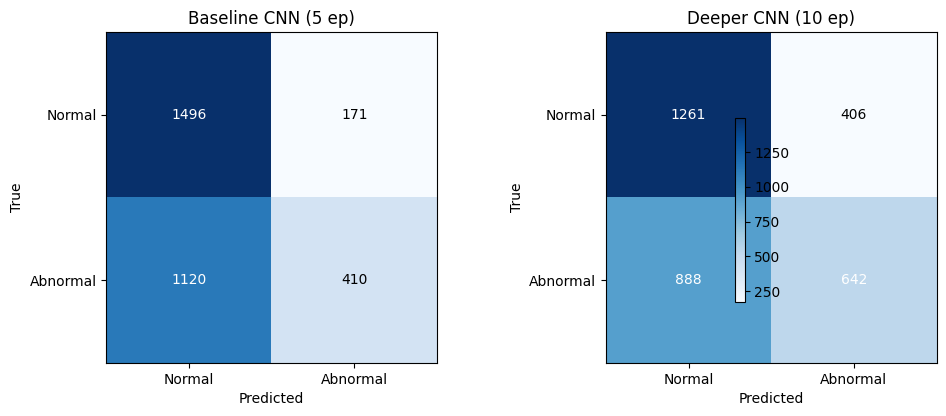

=== Baseline CNN (5 epochs) – Classification report ===
              precision    recall  f1-score   support

  Normal (0)      0.572     0.897     0.699      1667
Abnormal (1)      0.706     0.268     0.388      1530

    accuracy                          0.596      3197
   macro avg      0.639     0.583     0.544      3197
weighted avg      0.636     0.596     0.550      3197


=== Deeper CNN (10 epochs) – Classification report ===
              precision    recall  f1-score   support

  Normal (0)      0.587     0.756     0.661      1667
Abnormal (1)      0.613     0.420     0.498      1530

    accuracy                          0.595      3197
   macro avg      0.600     0.588     0.579      3197
weighted avg      0.599     0.595     0.583      3197



In [ ]:
#Confusion matrices + classification reports (threshold = 0.5)

threshold = 0.5

# Baseline
y_true_base = baseline_results["y_true"]
y_prob_base = baseline_results["y_prob"]
y_pred_base = (y_prob_base >= threshold).astype(int)
cm_base = confusion_matrix(y_true_base, y_pred_base)
report_base = classification_report(
    y_true_base,
    y_pred_base,
    target_names=["Normal (0)", "Abnormal (1)"],
    digits=3,
)

# Deeper CNN (10 epochs)
y_true_m10 = model10_results["y_true"]
y_prob_m10 = model10_results["y_prob"]
y_pred_m10 = (y_prob_m10 >= threshold).astype(int)
cm_m10 = confusion_matrix(y_true_m10, y_pred_m10)
report_m10 = classification_report(
    y_true_m10,
    y_pred_m10,
    target_names=["Normal (0)", "Abnormal (1)"],
    digits=3,
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

def plot_cm(ax, cm, title):
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Normal", "Abnormal"])
    ax.set_yticklabels(["Normal", "Abnormal"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    thresh = cm.max() / 2.0
    for i in range(2):
        for j in range(2):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    return im

im = plot_cm(axes[0], cm_base, "Baseline CNN (5 ep)")
plot_cm(axes[1], cm_m10, "Deeper CNN (10 ep)")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.tight_layout()
plt.show()

print("=== Baseline CNN (5 epochs) – Classification report ===")
print(report_base)

print("\n=== Deeper CNN (10 epochs) – Classification report ===")
print(report_m10)
